# 5. Segregation Indexes

Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time. First, we import the data and libraries ised for the creation of the functions in the Prerequiste section. Then We calculate The Freeman Segregation Index and the Spectral Segregatoin Index in The next Sections

## 1. Prerequistes

In [1]:
import numpy as np
import pandas as pd
import pickle
import graph_tool as gt
from graph_tool.spectral import adjacency
import scipy.sparse as sp
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load Types Matrix
data = np.load('/mnt/disk2/Data/Matrices/Useful_Matrices/types_matrix.npz')
indices = data['indices']
indptr = data['indptr']
shape = data['shape']
data = data['data']
types = sp.csr_matrix((data, indices, indptr), shape = shape)
print(f'There are {types.shape[0]} nodes and {types.shape[1]} Groups')

# Load Types DF
types_df = pd.read_pickle('/mnt/disk2/Data/Pickle/types_indicator_df.pkl')

# Load user_indices file for filtering
with open('/mnt/disk2/Data/Pickle/user_indices.pkl', 'rb') as file:
    user_indices = pickle.load(file)

There are 37337 nodes and 4 Groups


In [3]:
#In this first attempt, our types matrix looks like this
N, K = types.shape
Eta_k = []
for k in range(K):
    Eta = np.sum(types[:,k])
    Eta_k.append(Eta)
Eta_k = np.array(Eta_k)

# We show this amounts
print(f'Tweets de Derecha: {Eta_k[0]}')
print(f'Tweets de Izquierda: {Eta_k[1]}')
print(f'Tweets de Centro: {Eta_k[2]}')
print(f'No Retweets: {Eta_k[3]}')

Tweets de Derecha: 6812
Tweets de Izquierda: 23138
Tweets de Centro: 3543
No Retweets: 3844


In [76]:
def freeman(adj: np.array, types: np.array) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

    Returns:
        type: Segregation Index of Freeman

    """
    # We get the amount of vertices and groups
    N, K = types.shape
    
    # Get the amount of nodes per group
    Eta_k =[]
    for k in range(K):
        Eta = np.sum(types[:, k])
        Eta_k.append(Eta)
    Eta_k = np.array(Eta_k)
    
    # Calculate the contact layer Corresponds to the number of relation between and within groups acoording to the groups indexes
    M = types.transpose().dot(adj).dot(types)
    M = M.toarray()
    M = np.triu(M)
    M_no_diag = np.triu(M,k=1)

    # Calculate P 
    P = M_no_diag.sum() / M.sum()

    # Prepare for calculation
    numerator = P * N * (N - 1)
    denominator = (Eta_k.sum() **2) - (np.sum(Eta_k **2))

    # calculate using the formula
    S = 1 - (numerator / denominator)
    
    return S

In [139]:
# SANDBOX

# Example Adjacency
data = np.load('/mnt/disk2/Data/Matrices/3_Day_Window/adj_end_of_01-05-2021.csr.npz')
indices = data['indices']
indptr = data['indptr']
shape = data['shape']
data = data['data']
adj = sp.csr_matrix((data, indices, indptr), shape = shape)
adj = sp.csr_matrix.tolil(adj)

# Normalize adjacency
row_sums = adj.sum(axis=1).A.ravel()
R = adj / row_sums[:, np.newaxis]
R = R.tocsr()

# Get one group Sub Matrix
# Get the group Indexes
centro_id = types_df[types_df['Dummy Centro'] == 1].index

# get the filter for the Adjcacency
filter = []
for user in centro_id:
    filter.append(user_indices[user])
filter

# Get sub Matrix
ixgrid = np.ix_(filter,filter)
C = R[ixgrid]
C = C.toarray()

# Get Max EigenValue
SSI_C = np.linalg.eig(C)
SSI_value = np.max(SSI_C.eigenvalues)
SSI_value

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/scipy/sparse/_base.py:659: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


(1+0j)

In [ ]:
def Sepctral_Segregation_Index(adj: np.array, types: np.array, user_indices: dict) -> float:
    """
    Description of your function.

    Args:
        adj (Array like): The adjacency matrix of the graph for constructing the index
        
        types (Array like): Matrix of N rows (Number of Nodes) and K columns (Number of Groups) where each entry of the matrix
        specifies if that Node of row 'i' belongs to the group 'k' in column 'k'.

    Returns:
        type: Segregation Index of Freeman

    """

    # Normalize adjacency
    row_sums = adj.sum(axis=1).A.ravel()
    R = adj / row_sums[:, np.newaxis]
    R = R.tocsr()

    # Get the group Indexes
    centro_id = types_df[types_df['Dummy Centro'] == 1].index

    # get the filter for the Adjcacency
    filter = []
    for user in centro_id:
        filter.append(user_indices[user])
    filter

    # Get sub Matrix
    ixgrid = np.ix_(filter,filter)
    C = R[ixgrid]
    C = C.toarray()

    # Get Max EigenValue
    SSI_C = np.linalg.eig(C)
    SSI_value = np.max(SSI_C.eigenvalues)
    SSI_value


In [129]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

# Create a sparse CSR matrix (replace this with your matrix)
data = np.array([3, 2, 1, 4])
row_indices = np.array([0, 1, 1, 2])
column_indices = np.array([1, 2, 3, 2])
matrix = csr_matrix((data, (row_indices, column_indices)), shape=(4, 4))

# Compute eigenvalues (k=2 means compute the 2 largest eigenvalues)
num_eigenvalues = 2
eigenvalues, _ = eigs(matrix, k=num_eigenvalues)

print("Eigenvalues:")
print(eigenvalues)


ValueError: matrix type must be 'f', 'd', 'F', or 'D'

## 2. 3 Day rolling window Segregation Indexes

In [77]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')
data_viz = []

for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    #Appending it to the data Visualization list
    data = {
        'date': [adjacency_name],
        'segregation': [freeman(adj,types)]
    }
    df = pd.DataFrame(data, index = None)
    data_viz.append(df)

# We create a Dataframe for Visualization
data_viz = pd.concat(data_viz)

# Transform the list to a big dataframe
data_viz['date'] = pd.to_datetime(data_viz['date'], format='%d-%m-%Y')

In [78]:
data_viz

,date,segregation
0,2021-05-26,0.755996
0,2021-06-03,0.761994
0,2021-05-05,0.749444
0,2021-05-09,0.783448
0,2021-06-24,0.719959
...,...,...
0,2021-05-27,0.752179
0,2021-06-01,0.792495
0,2021-05-22,0.776901
0,2021-05-25,0.761262


/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


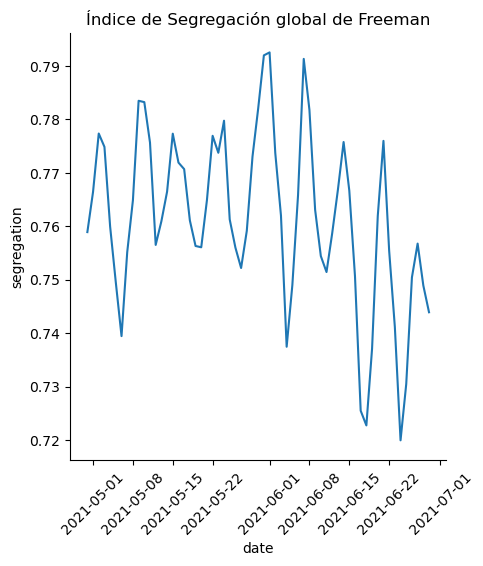

In [79]:
# Data Visualization
sns.relplot(data = data_viz,
            x ='date',
            y ='segregation',
            kind = 'line')
plt.title('Índice de Segregación global de Freeman')
plt.xticks(rotation=45)
plt.show()